In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

In [2]:
sp_data = sc.read('../datas/human_prefrontal_cortex/slide_tag_human_spatial.h5ad')
sp_data

AnnData object with n_obs × n_vars = 4065 × 28568
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'spatial'

In [3]:
sc_data = sc.read('../datas/human_prefrontal_cortex/GSE124952_10X_mouse_scrna.h5ad')
sc_data

AnnData object with n_obs × n_vars = 24822 × 19517
    obs: 'nGene', 'nUMI', 'percent.mito', 'Sample', 'treatment', 'Period', 'stage', 'CellType', 'L2_clusters', 'DevStage', 'celltype'
    var: 'n_cells'

In [4]:
sc_data.obs

,nGene,nUMI,percent.mito,Sample,treatment,Period,stage,CellType,L2_clusters,DevStage,celltype
PFCSample11_CTGTTTAGTATGAATG,5173,24107,0.016468,PFCSample11,Saline,withdraw_15d,withdraw_15d_Saline,Astro,Exc_25,Adult,Astro
PFCSample11_GCTCTGTAGCTCCCAG,2267,4852,0.083059,PFCSample11,Saline,withdraw_15d,withdraw_15d_Saline,Astro,Inhib_3,Adult,Astro
PFCSample9_AGCTCCTAGTGAACAT,2805,6758,0.019236,PFCSample9,Cocaine,withdraw_15d,withdraw_15d_Cocaine,Astro,Inhib_4,Adult,Astro
PFCSample2_CATGACAGTGTTCGAT,1091,2446,0.038430,PFCSample2,Saline,Maintenance,Maintenance_Saline,Astro,Astro_7,Adult,Astro
PFCSample7_GACTAACAGCTGCCCA,1774,4416,0.033514,PFCSample7,Saline,withdraw_48h,withdraw_48h_Saline,Astro,Astro_7,Adult,Astro
...,...,...,...,...,...,...,...,...,...,...,...
PFCSample8_ATGCGATCAATGGAGC,1835,7950,0.019119,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia
PFCSample8_CTCGGAGTCAGTTGAC,1773,5900,0.031356,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia
PFCSample8_GCAATCACAAGGACTG,1369,3788,0.034055,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia
PFCSample8_GGACAAGGTCGAGTTT,1303,3518,0.022172,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia


In [5]:
sc.pp.normalize_total(sc_data)
sc.pp.log1p(sc_data)

sc.pp.normalize_total(sp_data)
sc.pp.log1p(sp_data)

In [6]:
mouse_2_human_genelist = pd.read_csv('../datas/human_prefrontal_cortex/mouse2human_genelist.txt',
                                     index_col=None, sep='\t')
mouse_2_human_genelist = mouse_2_human_genelist.dropna()
mouse_2_human_genelist

,mouse.Gene.name,Human.gene.name
0,mt-Nd1,MT-ND1
1,mt-Nd2,MT-ND2
2,mt-Co1,MT-CO1
3,mt-Co2,MT-CO2
4,mt-Atp8,MT-ATP8
...,...,...
17123,Nop10,NOP10
17124,a,ASIP
17125,Gins1,GINS1
17126,Ninl,NINL


In [7]:
sp_data = sp_data[:, sp_data.var_names.isin(mouse_2_human_genelist['Human.gene.name'])]
sp_data

View of AnnData object with n_obs × n_vars = 4065 × 14927
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'

In [8]:
sc_data = sc_data[:, sc_data.var_names.isin(mouse_2_human_genelist['mouse.Gene.name'])]
sc_data

View of AnnData object with n_obs × n_vars = 24822 × 13281
    obs: 'nGene', 'nUMI', 'percent.mito', 'Sample', 'treatment', 'Period', 'stage', 'CellType', 'L2_clusters', 'DevStage', 'celltype'
    var: 'n_cells'
    uns: 'log1p'

In [9]:
mouse_2_human_genedict = dict(zip(mouse_2_human_genelist['mouse.Gene.name'].tolist(), 
                                 mouse_2_human_genelist['Human.gene.name'].tolist()))

sc_data.var['mouse_gene_name'] = sc_data.var_names
sc_data.var['mouse_2_human_gene_name'] = sc_data.var['mouse_gene_name'].replace(mouse_2_human_genedict)

sc_data.var_names = sc_data.var['mouse_2_human_gene_name']
sc_data.var_names.name = None
sc_data.var

,n_cells,mouse_gene_name,mouse_2_human_gene_name
CREM,11897,Crem,CREM
CUL2,8830,Cul2,CUL2
BAMBI,850,Bambi,BAMBI
MAP3K8,2022,Map3k8,MAP3K8
MTPAP,7696,Mtpap,MTPAP
...,...,...,...
LTB4R2,3,Ltb4r2,LTB4R2
SYCP2L,3,Sycp2l,SYCP2L
ISL1,6,Isl1,ISL1
ABCG5,4,Abcg5,ABCG5


In [10]:
sc_data.obs['cell_type'] = sc_data.obs['celltype']
sp_data.obs['cell_type'] = sp_data.obs['celltype']

# Process data

In [11]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [12]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

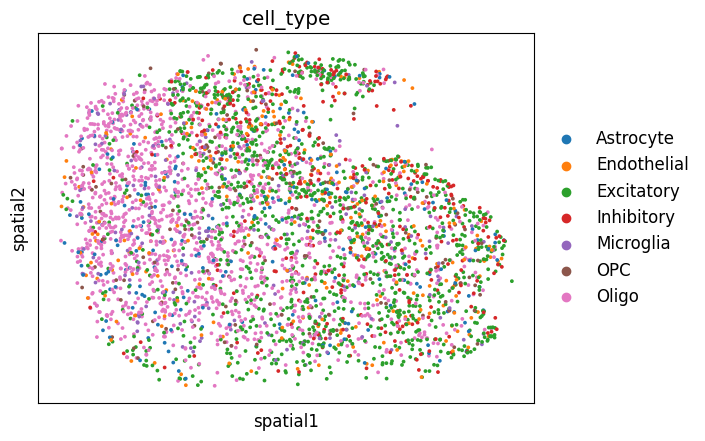

In [13]:
sc.pl.embedding(sp_data, basis='spatial', color='cell_type')

In [14]:
cell_mapping = {
    "Astro": "Astrocyte", 
    "Endo": "Endothelial",
    "NF Oligo": "Oligo", 
}

sc_data.obs['cell_type'] = sc_data.obs['celltype'].replace(cell_mapping)
sc_data.obs

,nGene,nUMI,percent.mito,Sample,treatment,Period,stage,CellType,L2_clusters,DevStage,celltype,cell_type
PFCSample11_CTGTTTAGTATGAATG,5173,24107,0.016468,PFCSample11,Saline,withdraw_15d,withdraw_15d_Saline,Astro,Exc_25,Adult,Astro,Astrocyte
PFCSample11_GCTCTGTAGCTCCCAG,2267,4852,0.083059,PFCSample11,Saline,withdraw_15d,withdraw_15d_Saline,Astro,Inhib_3,Adult,Astro,Astrocyte
PFCSample9_AGCTCCTAGTGAACAT,2805,6758,0.019236,PFCSample9,Cocaine,withdraw_15d,withdraw_15d_Cocaine,Astro,Inhib_4,Adult,Astro,Astrocyte
PFCSample2_CATGACAGTGTTCGAT,1091,2446,0.038430,PFCSample2,Saline,Maintenance,Maintenance_Saline,Astro,Astro_7,Adult,Astro,Astrocyte
PFCSample7_GACTAACAGCTGCCCA,1774,4416,0.033514,PFCSample7,Saline,withdraw_48h,withdraw_48h_Saline,Astro,Astro_7,Adult,Astro,Astrocyte
...,...,...,...,...,...,...,...,...,...,...,...,...
PFCSample8_ATGCGATCAATGGAGC,1835,7950,0.019119,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia,Microglia
PFCSample8_CTCGGAGTCAGTTGAC,1773,5900,0.031356,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia,Microglia
PFCSample8_GCAATCACAAGGACTG,1369,3788,0.034055,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia,Microglia
PFCSample8_GGACAAGGTCGAGTTT,1303,3518,0.022172,PFCSample8,Cocaine,withdraw_48h,withdraw_48h_Cocaine,Microglia,Microglia_1,Adult,Microglia,Microglia


In [15]:
# # Find common cell types
common_cell_type = list(set(sp_data.obs['cell_type'].tolist()) & set(sc_data.obs['cell_type'].tolist()))
common_cell_type

['Inhibitory',
 'OPC',
 'Excitatory',
 'Astrocyte',
 'Oligo',
 'Endothelial',
 'Microglia']

In [16]:
sp_data = sp_data[sp_data.obs['cell_type'].isin(common_cell_type), :]
sp_data

View of AnnData object with n_obs × n_vars = 4065 × 14927
    obs: 'celltype', 'cell_type'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p', 'cell_type_colors'
    obsm: 'spatial'

In [17]:
sc_data = sc_data[sc_data.obs['cell_type'].isin(common_cell_type), :]
sc_data

View of AnnData object with n_obs × n_vars = 24822 × 13281
    obs: 'nGene', 'nUMI', 'percent.mito', 'Sample', 'treatment', 'Period', 'stage', 'CellType', 'L2_clusters', 'DevStage', 'celltype', 'cell_type'
    var: 'n_cells', 'mouse_gene_name', 'mouse_2_human_gene_name'
    uns: 'log1p'

# Run code

In [18]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [19]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

In [20]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

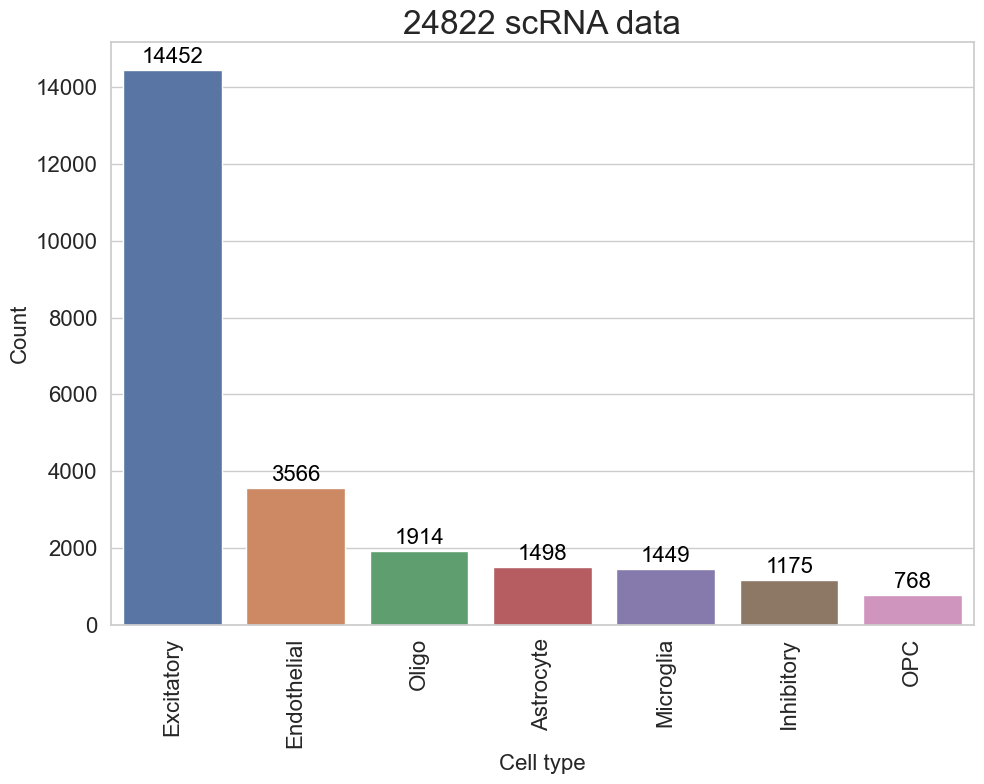

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

datatype = 'Seq'
assert datatype in ['FISH', 'Seq']

scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, hvg_num=50000, 
                                             final_n_top_genes=15000, min_genes_in_cells=3, datatype=datatype)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 24822 cells  ||  scRNA Data after filtering: 24784 cells
scRNA Data already normalized. Skipping normalization.
sc data nonzero expression ratio: 18.89%
-----------------------------------------------
Preprocessing spRNA-seq data ...
spRNA Data already normalized. Skipping normalization.
-----------------------------------------------
Enhance spRNA Data expression ...


100%|███████████████████████████████████████████████████████████████████████████| 4065/4065 [00:00<00:00, 31758.10it/s]
Enhance gene expression data using spatial coordinates: 100%|████████████████████| 4065/4065 [00:01<00:00, 3138.98it/s]


sp data original nonzero expression ratio: 9.36%    sp data enhanced nonzero expression ratio: 35.91%
Concatenating datasets...
We have 12656 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 12656 genes for training ...
Preprocessing completed...


In [23]:
save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, verbose=True,
                              batch_size=256, loss_step=1, n_epochs=10, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (24784, 12656)
Size of spRNA-seq data Input:  (4065, 12656)
Class distribution: [ 1497  3537 14452  1175  1443   768  1912]
Class weights: [0.14781015 0.13226399 0.11283116 0.15286991 0.14855607 0.16264202
 0.14302671]
Train the model..........


Training:  10%|███████▎                                                                 | 1/10 [00:01<00:12,  1.43s/it]

Epoch:1 MMD Loss:4.083  Class Loss:12.368  Recon loss: 872.009  Train_Accuracy: 75.44% 


Training:  20%|██████████████▌                                                          | 2/10 [00:02<00:08,  1.03s/it]

Epoch:2 MMD Loss:3.590  Class Loss:3.285  Recon loss: 1813.735  Train_Accuracy: 96.29% 


Training:  30%|█████████████████████▉                                                   | 3/10 [00:02<00:06,  1.12it/s]

Epoch:3 MMD Loss:3.185  Class Loss:1.332  Recon loss: 1781.149  Train_Accuracy: 98.12% 


Training:  40%|█████████████████████████████▏                                           | 4/10 [00:03<00:04,  1.22it/s]

Epoch:4 MMD Loss:2.785  Class Loss:0.876  Recon loss: 1221.637  Train_Accuracy: 98.78% 


Training:  50%|████████████████████████████████████▌                                    | 5/10 [00:04<00:03,  1.27it/s]

Epoch:5 MMD Loss:2.438  Class Loss:0.631  Recon loss: 909.447  Train_Accuracy: 99.19% 


Training:  60%|███████████████████████████████████████████▊                             | 6/10 [00:05<00:03,  1.30it/s]

Epoch:6 MMD Loss:2.046  Class Loss:0.647  Recon loss: 731.969  Train_Accuracy: 99.15% 


Training:  70%|███████████████████████████████████████████████████                      | 7/10 [00:05<00:02,  1.33it/s]

Epoch:7 MMD Loss:1.815  Class Loss:0.430  Recon loss: 597.119  Train_Accuracy: 99.17% 


Training:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [00:06<00:01,  1.34it/s]

Epoch:8 MMD Loss:1.558  Class Loss:0.386  Recon loss: 504.885  Train_Accuracy: 99.41% 


Training:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [00:07<00:00,  1.34it/s]

Epoch:9 MMD Loss:1.460  Class Loss:0.247  Recon loss: 435.403  Train_Accuracy: 99.68% 


Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.25it/s]


Epoch:10 MMD Loss:1.295  Class Loss:0.296  Recon loss: 382.168  Train_Accuracy: 99.46% 
Testing the model..........


Testing scRNA data: 100%|██████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 54.21it/s]


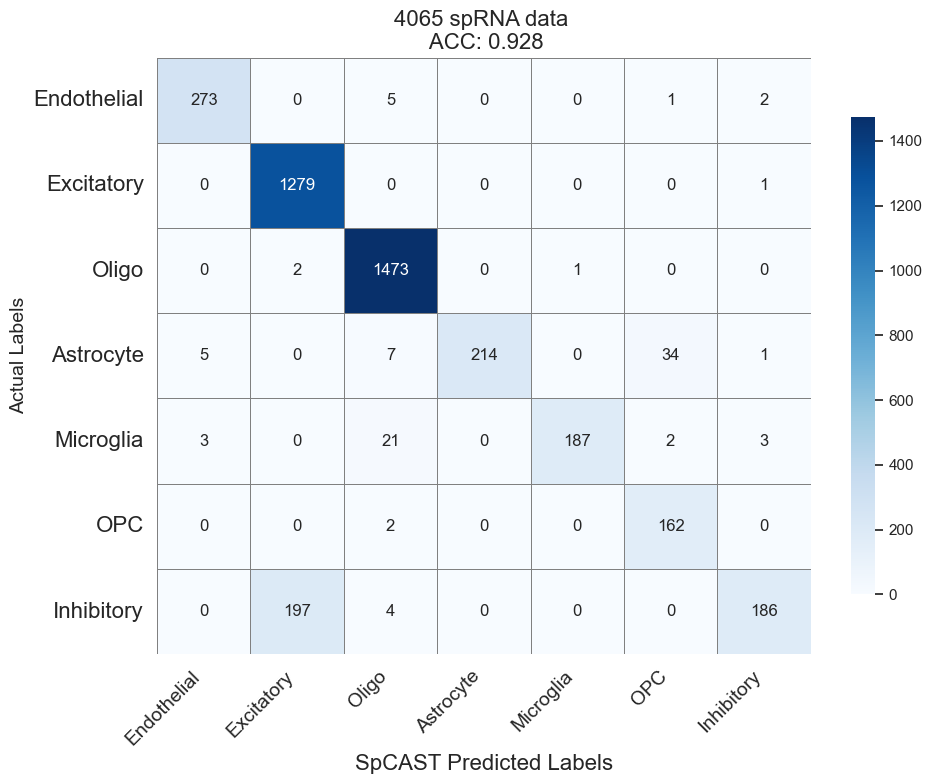

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Get unique category labels
cell_labels = spRNA_data.obs['cell_type'].unique().tolist()

spRNA_data.obs.cell_type = spRNA_data.obs.cell_type.astype(str)
spRNA_data.obs.SpCAST_predicted = spRNA_data.obs.SpCAST_predicted.astype(str)

# Calculate confusion matrix
conf_matrix = confusion_matrix(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], labels=cell_labels)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=cell_labels, columns=cell_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'shrink': 0.8},  # Shrink color bar
            linewidths=0.5,  # Add grid line width
            linecolor='grey')  # Set grid line color

# Add axis labels and title
plt.xlabel('SpCAST Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=16)  # Keep y-axis labels horizontal

# Calculate accuracy and update the title
accuracy = accuracy_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'])
f1 = f1_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], average='macro')

plt.title(f'{len(spRNA_data.obs)} spRNA data \n ACC: {accuracy:.3f}', fontsize=16)
# Display the plot
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure
plt.show()